# Extraction de connaissances à partir de données structurées et non structurées

## Séance 7 : Modélisation supervisée via différentes modèles

### Utilisation de python

L'idée de cette séance est de voir l'utilisation de différentes méthodes pour la classification supervisée (*création d'un modèle permettant de prédire une variable de type binaire*). Ainsi, nous utiliserons les modèles suivants :

- $k$-plus proches voisins
- Arbres de décision
- Réseaux de neurones


## Données de travail

Nous allons réutiliser les données `spam` que nous avons utiliser la dernière fois

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")

url_spam = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
spam = pandas.read_csv(url_spam, header = None)

url_names = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names"
spam_names = pandas.read_table(url_names, sep = ":", header = None, skiprows = 33, names = ["var", "type"])

spam.columns = list(spam_names["var"]) + ["spam"]
spam

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


Toutes les fonctions dans `sklearn` utilisent le même formalisme, à savoir la séparation des données en deux objets :

- `X` qui contient les variables explicatives
- `y` qui contient la variable à expliquer

In [2]:
X = spam.drop(["spam"], axis = 1)
y = (spam["spam"] == 1)

## $k$-plus proches voisins (ou $k$-NN - $k$-nearest neightbors)

L'idée de cette méthode, comme son nom l'indique, de rechercher un certain nombre de points proches de celui à prédire. Ce nombre $k$ est un des paramètre de la méthode, l'autre étant la méthode à utiliser pour calculer la distance entre deux points (très souvent la distance euclidienne).

Cette méthode a l'avantage d'être rapide, applicable à des données de grandes tailles et ne nécessite pas d'hypothèse forte. Par contre, si la méthode trouvent deux voisins à une distance identique, selon le cas, elle peut n'en retenir qu'un des deux (le premier dans la liste). Et si la valeur de $y$ est différente entre les deux, cela impacte très fortement les résultats.

### Avec $k=5$

In [3]:
from sklearn.neighbors import KNeighborsClassifier

m_knn = KNeighborsClassifier(n_neighbors = 5).fit(X, y)

In [4]:
m_knn.predict(X) * 1

array([1, 1, 1, ..., 0, 0, 0])

In [5]:
t = pandas.crosstab(m_knn.predict(X), y)
t

spam,False,True
row_0,,
False,2506,304
True,282,1509


In [6]:
m_knn.score(X, y)

0.8726363833949141

### En variant le nombre de voisins $k$

On remarque ici que c'est en choisissant $k=1$ que l'on obtient les meilleurs résultats.

In [7]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

r2 = []
roc_auc = []
vn = []
fn = []
fp = []
vp = []

k_val = (1, 2, 5, 10, 15, 20)
for k in k_val:
    m_knn = KNeighborsClassifier(n_neighbors = k).fit(X, y)
    r2 = r2 + [m_knn.score(X, y)]
    fpr, tpr, th = roc_curve(y, pandas.DataFrame(m_knn.predict_proba(X))[1])
    roc_auc = roc_auc + [auc(fpr, tpr)]
    p = m_knn.predict(X) * 1
    vn = vn + [sum((1 - y) * (1 - p))]
    fn = fn + [sum((1 - y) * p)]
    fp = fp + [sum(y * (1 - p))]
    vp = vp + [sum(y * p)]
    
df = pandas.DataFrame({
    "variable": k_val,
    "rsquared": r2,
    "auc": roc_auc,
    "vrais_negatifs": vn,
    "faux_negatifs": fn,
    "faux_positifs": fp,
    "vrais_positifs": vp
})
df

,variable,rsquared,auc,vrais_negatifs,faux_negatifs,faux_positifs,vrais_positifs
0,1,0.999348,0.999462,2785,3,0,1813
1,2,0.915236,0.984954,2788,0,390,1423
2,5,0.872636,0.949614,2506,282,304,1509
3,10,0.833514,0.920485,2516,272,494,1319
4,15,0.818300,0.903792,2408,380,456,1357
5,20,0.805912,0.889513,2437,351,542,1271


## Arbres de décision

Cette méthode itérative cherche, à chaque noeud, la varaible explicative séparant le mieux les modalités à prédire. A la racine de l'arbre, il y a donc tous les individus, et la population est séparée en deux sous-population pour dans chaque fils. L'algorithme permet de définir quelle variable, et surtout quel seuil (dans le cas d'une variable quantitative) ou quelle répartition de modalités (dans le cas d'une variable qualitative), permet de mieux séparer les classes à prédire.

Cette méthode est intéressante, car elle permet de voir rapidement quelles sont les variables ayant le plus d'impact sur la classe à prédire (ce sont celles en premier dans l'arbre). Il existe différentes méthodes dans la façon de choisir la variable (*CART* par défaut dans `sklearn`). Son défaut principal est le sur-apprentissage possible, si l'arbre est trop profond. On parle alors d'*élagage* pour le rendre plus généralisable.

### Arbre complet

Vous remarquerez que les performances sont très impressionnantes (seulement 3 mails mal classés).

In [8]:
from sklearn.tree import DecisionTreeClassifier

m_tree = DecisionTreeClassifier().fit(X, y)

In [9]:
t = pandas.crosstab(m_tree.predict(X), y)
t

spam,False,True
row_0,,
False,2788,3
True,0,1810


In [10]:
m_tree.score(X, y)

0.9993479678330798

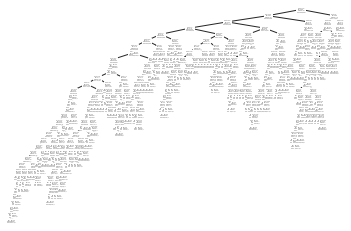

In [11]:
from sklearn.tree import plot_tree

plot_tree(m_tree)
plt.show()

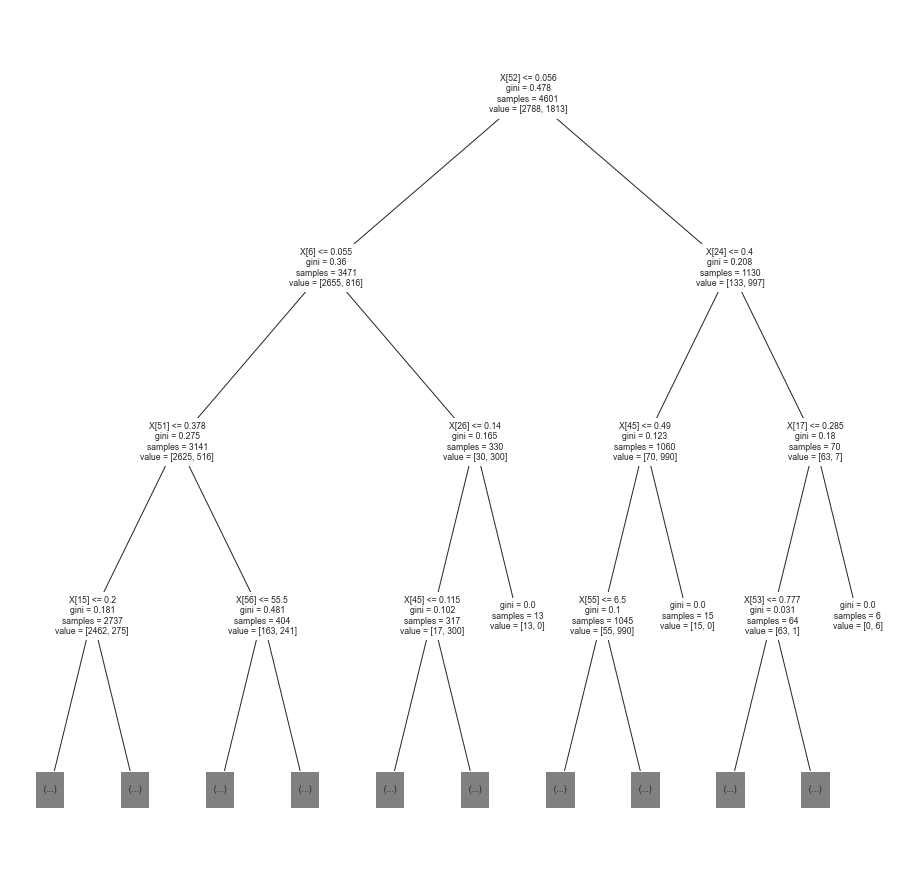

In [12]:
plt.figure(figsize=(16, 16))
plot_tree(m_tree, max_depth = 3)
plt.show()

### Arbre élagué

Comme indiqué plus haut, il est généralement préférable d'élaguer l'arbre (*i.e* de couper des branches) pour éviter le sur-apprentissage. Cela permet généralement que l'arbre ait de meilleures performances sur des nouvelles données. Pour cela, on utilise une méthode cherchant pour comment l'impureté des feuilles (*i.e.* la part d'individus mal classés) évolue en fonction d'une valeur `alpha`. Dans l'idéal, pour la choisir, on doit avoir un jeu de données d'apprentissage (*train*) et un jeu de données test (*test*).

Ici, au vu du graphique, nous choisissons une valeur de 0.005 (avec la méthode du coude).

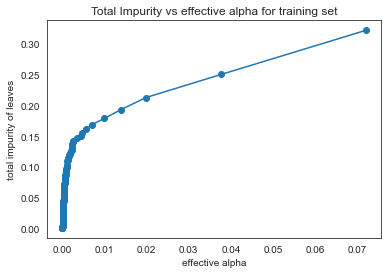

In [13]:
pruning = m_tree.cost_complexity_pruning_path(X, y)

fig, ax = plt.subplots()
ax.plot(pruning.ccp_alphas[:-1], pruning.impurities[:-1], marker="o") # , drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [14]:
m_tree_elague = DecisionTreeClassifier(ccp_alpha=0.005).fit(X, y)

In [15]:
t = pandas.crosstab(m_tree_elague.predict(X), y)
t

spam,False,True
row_0,,
False,2640,296
True,148,1517


In [16]:
m_tree_elague.score(X, y)

0.9034992392958052

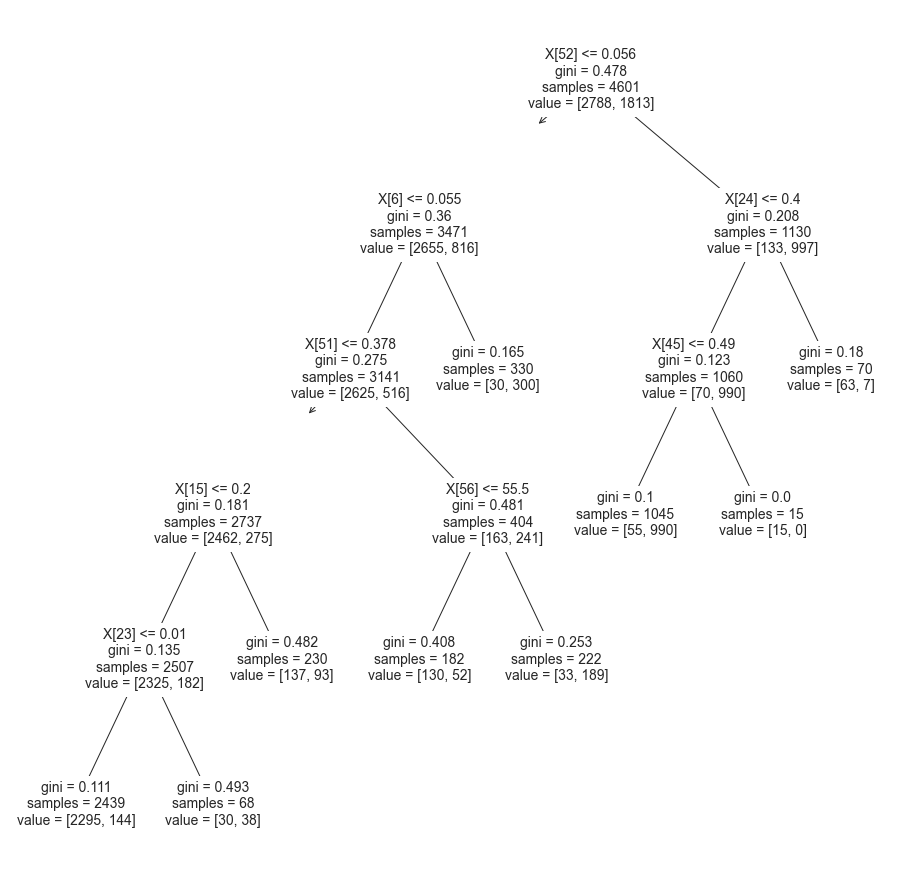

In [17]:
plt.figure(figsize=(16, 16))
plot_tree(m_tree_elague)
plt.show()

## Réseaux de neurones

On parle ici de perceptron (simple couche ou multi-couches, en fonction de la complexité que l'on souhaite). L'idée est de connecter des neurones d'entrée (qui prendront les valeurs des variables explicatives) à un neurone de sortie (ou plusieurs en fonction de la variable à expliquer donc). Entre les deux, il y a une ou plusieurs couches de neurones cachés, chacun complètement connecté aux neurones de la couche précédente et de la couche suivante. 

A partir de poids aléatoires sur chaque liaison entre neurones, l'algorithme propage l'erreur entre la valeur observée et la valeur prédite par le réseau à chaque couche, avec une méthode de back-propagation. Celle-ci permet de corriger les poids, afin que les neurones s'activent correctement. Cette méthode prend plusieurs paramètres comme le nombre de couches, la taille de chaque couche, la fonction d'activation d'un neurone, et d'autres encore. 

Un des défauts majeurs est la difficulté, principalement dans le cadre d'un réseau multi-couches, à percevoir l'impact d'une variable par rapport à une autre. L'autre défaut étant le nombre important de paramètres, et la variabilité des résultats en fonction des valeurs de ceux-ci. Malgré cela, les performances sont plutôt très intéressantes.

### Perceptron sans couche caché

Ici, on décide de n'avoir aucune couche caché, donc les neurones d'entrées sont directement connectés au neurone de sortie. Dans le cas d'une variable à expliquer quantitative, cela revient au modèle linéaire généralisé, pour information.

Pour notre cas, nous sommes obligé d'augmenter le nombre d'itérations pour que l'algorithme converge, avec des résultats plutôt bons.

In [18]:
from sklearn.neural_network import MLPClassifier

m_p = MLPClassifier(hidden_layer_sizes = (), max_iter = 1000).fit(X, y)

In [19]:
t = pandas.crosstab(m_p.predict(X), y)
t

spam,False,True
row_0,,
False,2658,183
True,130,1630


In [20]:
m_p.score(X, y)

0.9319713105846555

### Perceptron simple couche

Par défaut, la fonction choisit un réseau avec une couche cachée à 100 neurones, qui marche plutôt bien ici.

In [21]:
m_slp = MLPClassifier().fit(X, y)

In [22]:
t = pandas.crosstab(m_slp.predict(X), y)
t

spam,False,True
row_0,,
False,2667,187
True,121,1626


In [23]:
m_slp.score(X, y)

0.9330580308628559

### Perceptron multi-couches

Nous utilisons ici plusieurs couches, dont nous donnons la taille (*i.e.* nombre de neurones) dans le paramètre `hiden_layer_sizes`. Ici, après plusieurs essais (avec des choix empiriques), nous calculons un MLP avec 3 couches cachés de 100, 100 et 50 neurones respectivement.

In [24]:
m_mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 50)).fit(X,y)

In [25]:
t = pandas.crosstab(m_mlp.predict(X), y)
t

spam,False,True
row_0,,
False,2650,128
True,138,1685


In [26]:
m_mlp.score(X, y)

0.9421864811997391

## Exercice

A partir des même [données Spotify](https://www.kaggle.com/akiboy96/spotify-dataset) vu précédemment ce cours, nous souhaitons savoir s'il est possible de prédire le fait qu'une chanson soit populaire, ou non (variable `popularity`).

In [27]:
import pandas

spotify = pandas.read_csv("https://fxjollois.github.io/donnees/spotify_dataset.csv")
spotify

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,decade
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.4900,0.000000,0.0779,0.8450,185.655,173533,3,32.94975,9,1,60s
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.7970,101.801,213613,4,48.82510,10,0,60s
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.8460,0.000004,0.1190,0.9080,115.940,223960,4,37.22663,12,0,60s
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.7060,0.024600,0.0610,0.9670,105.592,157907,4,24.75484,8,0,60s
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.8570,0.000872,0.2130,0.9060,114.617,245600,4,21.79874,14,0,60s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41094,Lotus Flowers,Yolta,spotify:track:4t1TljQWJ6ZuoSY67zVvBI,0.172,0.358,9,-14.430,1,0.0342,0.8860,0.966000,0.3140,0.0361,72.272,150857,4,24.30824,7,0,10s
41095,Calling My Spirit,Kodak Black,spotify:track:2MShy1GSSgbmGUxADNIao5,0.910,0.366,1,-9.954,1,0.0941,0.0996,0.000000,0.2610,0.7400,119.985,152000,4,32.53856,8,1,10s
41096,Teenage Dream,Katy Perry,spotify:track:55qBw1900pZKfXJ6Q9A2Lc,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,0.1390,0.6050,119.999,227760,4,20.73371,7,1,10s
41097,Stormy Weather,Oscar Peterson,spotify:track:4o9npmYHrOF1rUxxTVH8h4,0.600,0.177,7,-16.070,1,0.0561,0.9890,0.868000,0.1490,0.5600,120.030,213387,4,21.65301,14,0,10s


#### A faire

Sur ces données :

- $k$-NN : essayer différentes valeurs de $k$ et choisir la plus intéressante
- Arbres de décision : calculer l'arbre élagué
- Réseaux de neurones : choisir la structure du réseau qui vous semble la plus intéressante
- Pour chaque modèle, commenter les résulats
- Comparer les modèles entre eux